#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [4]:
path = 'data/'
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [5]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비
* 서버 주소 사용

In [7]:
# Tracking 서버 설정
mlflow_uri = "http://mini7-mlflow.carpediem.so/"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* 팀에서 1명만 새 실험 생성 
    * exp_## (## : 팀 번호)
    * 팀원들과 exp id 공유

In [8]:
exp_id = mlflow.create_experiment("experiment_11")
exp_id

'39'

## 2.데이터 준비

### (1) 데이터 분할1 : x, y 나누기

In [9]:
x = data.drop('label', axis=1).values
y = data.loc[:, 'label'].values

### (2) 데이터 분할2 : train, test

* 적절하게 분할 하시오.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1000, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=2000, random_state=2023)

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

* shape 맞추기 n, 28,28,1

In [11]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [12]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 3.모델링
* 개인별 모델링 및 추적

### (1) 모델 추적

In [15]:
with mlflow.start_run(experiment_id=exp_id, run_name='a031084'):
    mlflow.keras.autolog()
    clear_session()

    # 모델 쌓기
    il = Input(shape=(28, 28, 1))

    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(il)
    hl = Conv2D(32, (3, 3), activation='relu', padding='same')(hl)
    hl = BatchNormalization()(hl)
    hl = MaxPooling2D()(hl)
    hl = Dropout(0.2)(hl)
    
    hl = Flatten()(hl)
    hl = Dense(512, activation='relu')(hl)
    hl = Dropout(0.2)(hl)
    ol = Dense(26, activation='softmax')(hl)

    # 모델 선언
    model = Model(il, ol)

    # 컴파일
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='adam')
    es = EarlyStopping(
        patience=5,
        min_delta=0,
        verbose=1
    )
    history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=30, batch_size=256, callbacks=[es]).history
    
    val_pred = model.predict(x_val).argmax(axis=1)
    val_acc = accuracy_score(y_val, val_pred)
    mlflow.log_metric("val_accuracy", val_acc)
    mlflow.keras.log_model(model, "model", registered_model_name="Sign_Signal_11")    
    mlflow.keras.autolog(disable=True)

Epoch 1/30
16/16 [==============================] - 14s 720ms/step - loss: 2.2616 - accuracy: 0.3842 - val_loss: 2.9390 - val_accuracy: 0.3420
Epoch 2/30
16/16 [==============================] - 11s 676ms/step - loss: 0.8136 - accuracy: 0.7492 - val_loss: 2.8513 - val_accuracy: 0.5030
Epoch 3/30
16/16 [==============================] - 11s 668ms/step - loss: 0.3820 - accuracy: 0.8848 - val_loss: 2.7243 - val_accuracy: 0.6280
Epoch 4/30
16/16 [==============================] - 10s 634ms/step - loss: 0.1670 - accuracy: 0.9567 - val_loss: 2.5276 - val_accuracy: 0.7360
Epoch 5/30
16/16 [==============================] - 9s 578ms/step - loss: 0.0812 - accuracy: 0.9822 - val_loss: 2.3568 - val_accuracy: 0.7810
Epoch 6/30
16/16 [==============================] - 9s 587ms/step - loss: 0.0457 - accuracy: 0.9918 - val_loss: 2.1891 - val_accuracy: 0.8900
Epoch 7/30
16/16 [==============================] - 9s 581ms/step - loss: 0.0284 - accuracy: 0.9950 - val_loss: 2.0414 - val_accuracy: 0.9010
Ep

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwfom221j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwfom221j\model\data\model\assets
2023/05/18 16:44:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\User\anaconda3\envs\ml_pipeline\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."


63/63 [==============================] - 1s 20ms/step


2023/05/18 16:44:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpl5z68us1\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpl5z68us1\model\data\model\assets
Registered model 'Sign_Signal_11' already exists. Creating a new version of this model...
2023/05/18 16:45:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal_11, version 3
Created version '3' of model 'Sign_Signal_11'.


* 학습곡선

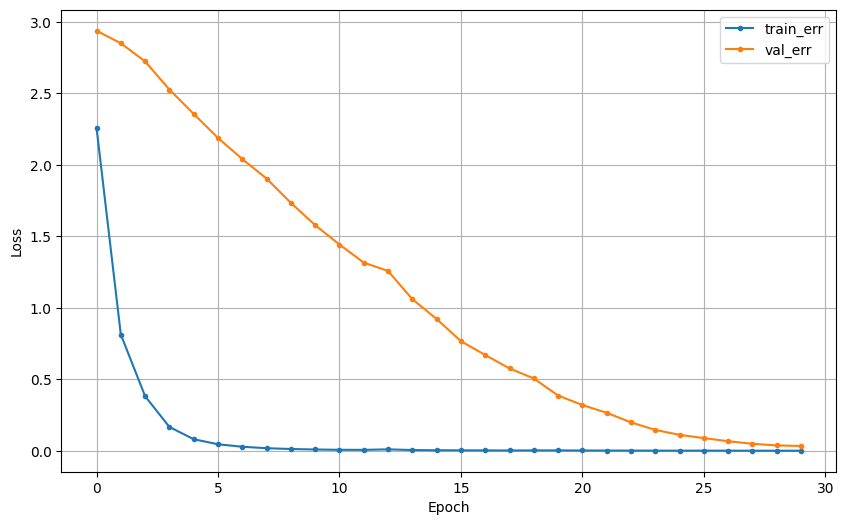

In [16]:
dl_history_plot(history)

* 예측 및 검증

In [17]:
y_pred = model.predict(x_val).argmax(axis=1)
print(confusion_matrix(y_val, y_pred))
print(classification_report(class_names[y_val], class_names[y_pred]))

63/63 [==============================] - 1s 20ms/step
[[87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 98  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 76  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 82  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 89  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 85  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 97  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 81  0  0

## 4.모델 사용하기
* 팀에서 1명만 mlflow server ui에 접속하여 
    * model_## 의 각 버전 중 성능이 가장 좋은 버전을 production으로 상태변경
* 팀원들은 각자 운영모델 로딩하고, 사용해보기
    * test 셋으로 예측 및 평가
    * test image 하나를 불러와서 예측

### (1) 운영모델 로딩

In [24]:
model_uri = "models:/Sign_Signal_11/production" 
model_p = mlflow.keras.load_model(model_uri)

### (2) test 데이터로 예측하고 평가

In [25]:
pred = model_p.predict(x_test)
pred_1 = pred.argmax(axis=1)

32/32 [==============================] - 0s 5ms/step


In [26]:
print(accuracy_score(y_test, pred_1))
print('-'*60)
print(confusion_matrix(y_test, pred_1))
print('-'*60)
print(classification_report(class_names[y_test], class_names[pred_1]))

1.0
------------------------------------------------------------
[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 41  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 

### (2) 이미지 로딩해서 사용하기
* 과제1 코드 참조

In [21]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

In [22]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

test_sign = test_sign / 255.

pred = model_p.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 21ms/step
['v']


In [ ]:
# # http://mini7-mlflow.carpediem.so/

# with mlflow.start_run(experiment_id=exp_id, run_name='a031084'):
#     mlflow.keras.autolog()

#     mlflow.keras.log_model(model, "keras-model", registered_model_name="Sign_Signal_11")    
#     mlflow.keras.autolog(disable=True)